In [12]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [13]:
# ============================================================================
# KONFIGURASI - EDIT BAGIAN INI
# ============================================================================

# Path ke dataset yang sudah di-split
TRAIN_DIR = '1_my_cloud/split/train'
VAL_DIR = '1_my_cloud/split/val'
TEST_DIR = '1_my_cloud/split/test'

# Folder untuk menyimpan model dan hasil
MODEL_SAVE_DIR = 'models_cloud_Similarity_Fisheye_4'
RESULTS_SAVE_DIR = 'results_cloud_Similarity_Fisheye_4'

# Hyperparameters
IMG_SIZE = (224, 224)       # Ukuran input gambar
BATCH_SIZE = 16             # Batch size untuk training
EPOCHS = 50                 # Maksimal epochs
LEARNING_RATE = 0.0001      # Learning rate

# Classes - akan auto-detect dari folder
# Tapi bisa di-set manual jika perlu urutan tertentu
CLASSES = None  # Auto-detect, atau set: ['Cumulus', 'Altocumulus', ...]


In [14]:
# ============================================================================
# SETUP
# ============================================================================

# Buat folder output
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(RESULTS_SAVE_DIR, exist_ok=True)

print("=" * 80)
print("🌥️  TRAINING MODEL CNN - KLASIFIKASI AWAN")
print("=" * 80)
print(f"Tanggal: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Algoritma: Transfer Learning (MobileNetV2)")
print("=" * 80)

# ============================================================================
# 1. VALIDASI DATASET
# ============================================================================

print("\n[1] Validasi Dataset...")

# Cek apakah folder ada
required_dirs = {
    'Train': TRAIN_DIR,
    'Validation': VAL_DIR,
    'Test': TEST_DIR
}

for name, path in required_dirs.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"❌ Folder {name} tidak ditemukan: {path}")
    print(f"   ✓ {name}: {path}")

🌥️  TRAINING MODEL CNN - KLASIFIKASI AWAN
Tanggal: 2026-02-06 16:03:06
Algoritma: Transfer Learning (MobileNetV2)

[1] Validasi Dataset...
   ✓ Train: 1_my_cloud/split/train
   ✓ Validation: 1_my_cloud/split/val
   ✓ Test: 1_my_cloud/split/test


In [15]:
# ============================================================================
# 2. DATA PREPROCESSING & AUGMENTATION
# ============================================================================

print("\n[2] Setup Data Preprocessing & Augmentation...")

# Data Augmentation untuk TRAINING
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    fill_mode='nearest'
)

# Hanya normalisasi untuk VALIDATION & TEST (tanpa augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data
print("\n   Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Load Validation Data
print("\n   Loading Validation Data...")
val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load Test Data
print("\n   Loading Test Data...")
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Ambil informasi classes
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

print(f"\n   ✅ Dataset Summary:")
print(f"      Training samples:   {train_generator.samples}")
print(f"      Validation samples: {val_generator.samples}")
print(f"      Test samples:       {test_generator.samples}")
print(f"      Total samples:      {train_generator.samples + val_generator.samples + test_generator.samples}")
print(f"      Classes ({num_classes}):       {class_names}")
print(f"      Class indices:      {train_generator.class_indices}")


[2] Setup Data Preprocessing & Augmentation...

   Loading Training Data...
Found 274 images belonging to 4 classes.

   Loading Validation Data...
Found 32 images belonging to 4 classes.

   Loading Test Data...
Found 38 images belonging to 4 classes.

   ✅ Dataset Summary:
      Training samples:   274
      Validation samples: 32
      Test samples:       38
      Total samples:      344
      Classes (4):       ['Cumulus', 'High_Cloud', 'Low_Cloud', 'Mid_Cloud']
      Class indices:      {'Cumulus': 0, 'High_Cloud': 1, 'Low_Cloud': 2, 'Mid_Cloud': 3}


In [16]:
# ============================================================================
# 3. BUILD MODEL
# ============================================================================

print("\n[3] Membangun Model CNN...")

# Load MobileNetV2 pretrained (ImageNet)
base_model = MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model untuk transfer learning
base_model.trainable = False

# Build model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("   ✅ Model berhasil dibangun")
print(f"\n   Arsitektur Model:")
model.summary()


[3] Membangun Model CNN...
   ✅ Model berhasil dibangun

   Arsitektur Model:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_2 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128) 

In [17]:
# ============================================================================
# 4. SETUP CALLBACKS
# ============================================================================

print("\n[4] Setup Callbacks...")

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_cloud_classification_{timestamp}.h5'
model_path = os.path.join(MODEL_SAVE_DIR, model_filename)

callbacks = [
    # Early Stopping - stop jika tidak ada improvement
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Model Checkpoint - save best model
    ModelCheckpoint(
        model_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    
    # Reduce Learning Rate - turunkan LR jika stuck
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    )
]

print("   ✅ Callbacks configured")



[4] Setup Callbacks...
   ✅ Callbacks configured


In [18]:
# ============================================================================
# 5. TRAINING MODEL
# ============================================================================

print("\n[5] Memulai Training...")
print("   Ini akan memakan waktu beberapa menit...")
print("-" * 80)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n   ✅ Training selesai!")
print(f"   Model tersimpan di: {model_path}")


[5] Memulai Training...
   Ini akan memakan waktu beberapa menit...
--------------------------------------------------------------------------------
Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 2.2349 - accuracy: 0.2664
Epoch 1: val_accuracy improved from -inf to 0.21875, saving model to models_cloud_Similarity_Fisheye_4\model_cloud_classification_20260206_160315.h5


d:\Skripsi\Coding\venv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 27s 1s/step - loss: 2.2349 - accuracy: 0.2664 - val_loss: 1.8386 - val_accuracy: 0.2188 - lr: 1.0000e-04
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 2.2693 - accuracy: 0.3358
Epoch 2: val_accuracy did not improve from 0.21875
18/18 [==============================] - 15s 815ms/step - loss: 2.2693 - accuracy: 0.3358 - val_loss: 1.8441 - val_accuracy: 0.1875 - lr: 1.0000e-04
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 2.0818 - accuracy: 0.3212
Epoch 3: val_accuracy did not improve from 0.21875
18/18 [==============================] - 17s 933ms/step - loss: 2.0818 - accuracy: 0.3212 - val_loss: 1.8387 - val_accuracy: 0.1562 - lr: 1.0000e-04
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 1.9909 - accuracy: 0.3175
Epoch 4: val_accuracy did not improve from 0.21875
18/18 [==============================] - 15s 822ms/step - loss: 1.9909 - accuracy: 0.3175 - val_loss: 1.8295 - val_accura

In [19]:
# ============================================================================
# 6. EVALUASI MODEL PADA TEST SET
# ============================================================================

print("\n[6] Evaluasi Model pada Test Set...")

# Load best model
best_model = keras.models.load_model(model_path)

# Reset test generator
test_generator.reset()

# Prediksi
print("   Melakukan prediksi...")
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Hitung metrik
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"\n   {'='*60}")
print("   HASIL EVALUASI MODEL")
print(f"   {'='*60}")
print(f"   Accuracy  : {accuracy*100:.2f}%")
print(f"   Precision : {precision*100:.2f}%")
print(f"   Recall    : {recall*100:.2f}%")
print(f"   F1-Score  : {f1*100:.2f}%")
print(f"   {'='*60}")

# Classification Report
print("\n   Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\n   Confusion Matrix:")
print(cm)


[6] Evaluasi Model pada Test Set...
   Melakukan prediksi...
3/3 [==============================] - 4s 542ms/step

   HASIL EVALUASI MODEL
   Accuracy  : 60.53%
   Precision : 64.01%
   Recall    : 60.53%
   F1-Score  : 60.57%

   Classification Report:
              precision    recall  f1-score   support

     Cumulus       0.30      0.75      0.43         4
  High_Cloud       0.67      0.60      0.63        10
   Low_Cloud       0.86      0.80      0.83        15
   Mid_Cloud       0.40      0.22      0.29         9

    accuracy                           0.61        38
   macro avg       0.56      0.59      0.54        38
weighted avg       0.64      0.61      0.61        38


   Confusion Matrix:
[[ 3  1  0  0]
 [ 3  6  0  1]
 [ 0  1 12  2]
 [ 4  1  2  2]]



[7] Membuat Visualisasi...
   ✅ Visualisasi tersimpan di: results_cloud_Similarity_Fisheye_4\training_results_20260206_160315.png


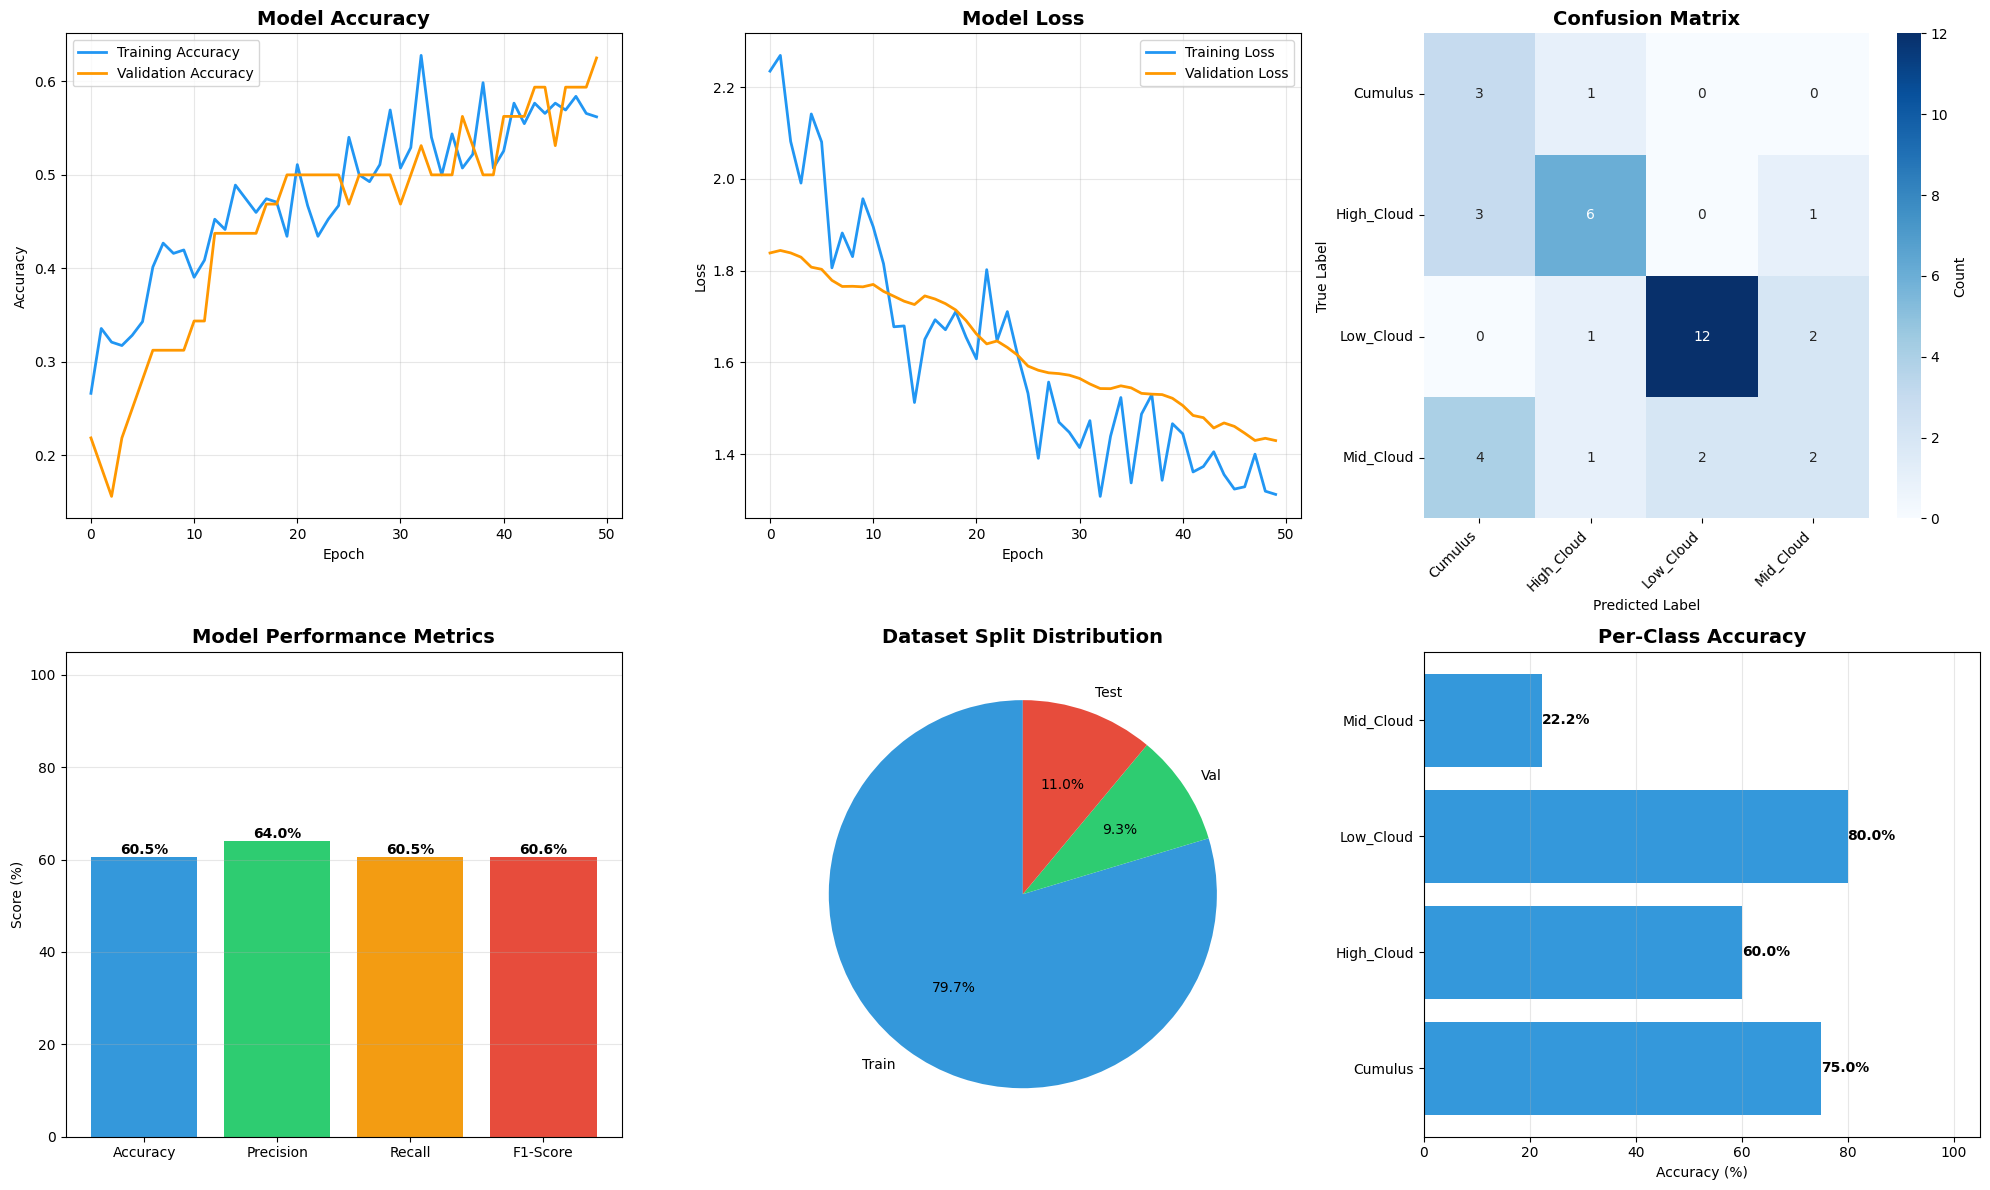

In [20]:
# ============================================================================
# 7. VISUALISASI HASIL
# ============================================================================

print("\n[7] Membuat Visualisasi...")

plt.style.use('default')
fig = plt.figure(figsize=(20, 12))

# 1. Training & Validation Accuracy
ax1 = plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2196F3')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#FF9800')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Training & Validation Loss
ax2 = plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, color='#2196F3')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#FF9800')
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Confusion Matrix
ax3 = plt.subplot(2, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# 4. Metrics Comparison
ax4 = plt.subplot(2, 3, 4)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy*100, precision*100, recall*100, f1*100]
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
bars = plt.bar(metrics, values, color=colors)
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score (%)')
plt.ylim(0, 105)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# 5. Dataset Distribution
ax5 = plt.subplot(2, 3, 5)
split_labels = ['Train', 'Val', 'Test']
split_values = [train_generator.samples, val_generator.samples, test_generator.samples]
colors_pie = ['#3498db', '#2ecc71', '#e74c3c']
plt.pie(split_values, labels=split_labels, autopct='%1.1f%%',
        colors=colors_pie, startangle=90)
plt.title('Dataset Split Distribution', fontsize=14, fontweight='bold')

# 6. Per-Class Accuracy
ax6 = plt.subplot(2, 3, 6)
per_class_accuracy = []
for i in range(num_classes):
    mask = y_true == i
    if mask.sum() > 0:
        acc = (y_pred[mask] == y_true[mask]).sum() / mask.sum()
        per_class_accuracy.append(acc * 100)
    else:
        per_class_accuracy.append(0)

bars = plt.barh(class_names, per_class_accuracy, color='#3498db')
plt.xlabel('Accuracy (%)')
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xlim(0, 105)
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2.,
             f'{width:.1f}%', ha='left', va='center', fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

# Save plot
chart_filename = f'training_results_{timestamp}.png'
chart_path = os.path.join(RESULTS_SAVE_DIR, chart_filename)
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
print(f"   ✅ Visualisasi tersimpan di: {chart_path}")


In [21]:
# ============================================================================
# 8. SIMPAN METADATA
# ============================================================================

print("\n[8] Menyimpan Metadata...")

metadata = {
    'timestamp': timestamp,
    'model_filename': model_filename,
    'model_path': model_path,
    'architecture': 'MobileNetV2 + Custom Layers',
    'input_shape': list(IMG_SIZE) + [3],
    'classes': class_names,
    'class_indices': train_generator.class_indices,
    'num_classes': num_classes,
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'learning_rate': LEARNING_RATE,
        'img_size': IMG_SIZE,
        'optimizer': 'Adam',
        'loss': 'categorical_crossentropy'
    },
    'dataset': {
        'train_samples': train_generator.samples,
        'validation_samples': val_generator.samples,
        'test_samples': test_generator.samples,
        'total_samples': train_generator.samples + val_generator.samples + test_generator.samples,
        'train_path': TRAIN_DIR,
        'val_path': VAL_DIR,
        'test_path': TEST_DIR
    },
    'performance': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'confusion_matrix': cm.tolist(),
        'per_class_accuracy': {class_names[i]: float(per_class_accuracy[i]) 
                              for i in range(num_classes)}
    },
    'training_history': {
        'final_train_accuracy': float(history.history['accuracy'][-1]),
        'final_val_accuracy': float(history.history['val_accuracy'][-1]),
        'final_train_loss': float(history.history['loss'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1]),
        'best_epoch': int(np.argmax(history.history['val_accuracy']) + 1),
        'total_epochs_trained': len(history.history['accuracy'])
    }
}

metadata_filename = f'model_metadata_{timestamp}.json'
metadata_path = os.path.join(RESULTS_SAVE_DIR, metadata_filename)

with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=4, ensure_ascii=False)

print(f"   ✅ Metadata tersimpan di: {metadata_path}")



[8] Menyimpan Metadata...
   ✅ Metadata tersimpan di: results_cloud_Similarity_Fisheye_4\model_metadata_20260206_160315.json


In [22]:
# ============================================================================
# 9. SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("✅ TRAINING SELESAI!")
print("=" * 80)

print(f"\n📊 HASIL AKHIR:")
print(f"   Accuracy:  {accuracy*100:.2f}%")
print(f"   Precision: {precision*100:.2f}%")
print(f"   Recall:    {recall*100:.2f}%")
print(f"   F1-Score:  {f1*100:.2f}%")

print(f"\n📁 OUTPUT FILES:")
print(f"   Model (.h5):     {model_path}")
print(f"   Visualisasi:     {chart_path}")
print(f"   Metadata (JSON): {metadata_path}")

print(f"\n📈 DATASET INFO:")
print(f"   Training:   {train_generator.samples} samples")
print(f"   Validation: {val_generator.samples} samples")
print(f"   Test:       {test_generator.samples} samples")

print(f"\n💡 NEXT STEPS:")
print(f"   1. Cek visualisasi di: {chart_path}")
print(f"   2. Cek metadata di: {metadata_path}")
print(f"   3. Gunakan model untuk klasifikasi: {model_path}")
print(f"   4. Jalankan 2_classify_mixed.py dengan MODEL_PATH = '{model_path}'")

print("=" * 80)

# Tampilkan plot
plt.show()



✅ TRAINING SELESAI!

📊 HASIL AKHIR:
   Accuracy:  60.53%
   Precision: 64.01%
   Recall:    60.53%
   F1-Score:  60.57%

📁 OUTPUT FILES:
   Model (.h5):     models_cloud_Similarity_Fisheye_4\model_cloud_classification_20260206_160315.h5
   Visualisasi:     results_cloud_Similarity_Fisheye_4\training_results_20260206_160315.png
   Metadata (JSON): results_cloud_Similarity_Fisheye_4\model_metadata_20260206_160315.json

📈 DATASET INFO:
   Training:   274 samples
   Validation: 32 samples
   Test:       38 samples

💡 NEXT STEPS:
   1. Cek visualisasi di: results_cloud_Similarity_Fisheye_4\training_results_20260206_160315.png
   2. Cek metadata di: results_cloud_Similarity_Fisheye_4\model_metadata_20260206_160315.json
   3. Gunakan model untuk klasifikasi: models_cloud_Similarity_Fisheye_4\model_cloud_classification_20260206_160315.h5
   4. Jalankan 2_classify_mixed.py dengan MODEL_PATH = 'models_cloud_Similarity_Fisheye_4\model_cloud_classification_20260206_160315.h5'
